In [1]:
import time
import pandas as pd
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.static import teams

In [2]:
def parse_matchup(matchup: str):
    # examples: "GSW vs LAL" or "GSW @ LAL"
    parts = matchup.split()
    team = parts[0]
    sep = parts[1]          # "vs" or "@"
    opp = parts[2]
    is_home = (sep == "vs")
    return opp, is_home

In [3]:
def fetch_player_game_logs_season(season: str, season_type: str = "Regular Season", sleep_s: float = 0.7):
    # season like "2016-17" or "1996-97"
    resp = leaguegamelog.LeagueGameLog(
        season=season,
        season_type_all_star=season_type,
        player_or_team_abbreviation="P"  # "P" = player logs
    )
    df = resp.get_data_frames()[0].copy()

    # standardize / parse fields
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
    df[["OPP_ABBREVIATION", "IS_HOME"]] = df["MATCHUP"].apply(
        lambda s: pd.Series(parse_matchup(s))
    )

    time.sleep(sleep_s)  # be polite
    return df

In [4]:
train_set_list = []

for i in range(1996, 2026):
    season = f"{i}-{str(i+1)[2:]}"
    train_set_list.append(fetch_player_game_logs_season(season, "Regular Season"))
    print("Fetched Season", season)

print(len(train_set_list))

Fetched Season 1996-97
Fetched Season 1997-98
Fetched Season 1998-99
Fetched Season 1999-00
Fetched Season 2000-01
Fetched Season 2001-02
Fetched Season 2002-03
Fetched Season 2003-04
Fetched Season 2004-05
Fetched Season 2005-06
Fetched Season 2006-07
Fetched Season 2007-08
Fetched Season 2008-09
Fetched Season 2009-10
Fetched Season 2010-11
Fetched Season 2011-12
Fetched Season 2012-13
Fetched Season 2013-14
Fetched Season 2014-15
Fetched Season 2015-16
Fetched Season 2016-17
Fetched Season 2017-18
Fetched Season 2018-19
Fetched Season 2019-20
Fetched Season 2020-21
Fetched Season 2021-22
Fetched Season 2022-23
Fetched Season 2023-24
Fetched Season 2024-25
Fetched Season 2025-26
30


In [5]:
temp = pd.concat(train_set_list)
# train_set.shape (582068, 34)

names = temp['PLAYER_NAME']
names = names.drop_duplicates().reset_index(drop=True)

In [6]:
import numpy as np

dates_df = pd.DataFrame()
i = 0

for name in names:
    i += 1
    name_partitioned_df = temp[temp['PLAYER_NAME'] == name]
    name_partitioned_df["DATE_DIFF_DAYS"] = name_partitioned_df["GAME_DATE"].diff().dt.days
    dates_df = pd.concat([dates_df, name_partitioned_df])
    print(f"{round(100*i/len(names),2)}% done, Appended {name}")

dates_df.head() # len(names) = 2,235

0.04% done, Appended Antonio Lang
0.07% done, Appended Bill Wennington
0.11% done, Appended Chris Gatling
0.14% done, Appended Jason Kidd
0.18% done, Appended Mark Jackson
0.21% done, Appended Eric Murdock
0.25% done, Appended Latrell Sprewell
0.28% done, Appended Todd Fuller
0.32% done, Appended Hakeem Olajuwon
0.35% done, Appended Matt Bullard
0.39% done, Appended Kevin Willis
0.43% done, Appended Matt Maloney
0.46% done, Appended Cedric Ceballos
0.5% done, Appended Nick Van Exel
0.53% done, Appended Travis Knight
0.57% done, Appended Kurt Thomas
0.6% done, Appended Darrin Hancock
0.64% done, Appended Armen Gilliam
0.67% done, Appended Glenn Robinson
0.71% done, Appended Vin Baker
0.74% done, Appended Andrew Lang
0.78% done, Appended James Robinson
0.82% done, Appended Cherokee Parks
0.85% done, Appended Kevin Garnett
0.89% done, Appended Patrick Ewing
0.92% done, Appended Felton Spencer
0.96% done, Appended Gerald Wilkins
0.99% done, Appended Jalen Rose
1.03% done, Appended Reggie W

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,OPP_ABBREVIATION,IS_HOME,DATE_DIFF_DAYS
0,21996,226,Antonio Lang,1610612739,CLE,Cleveland Cavaliers,0029600002,1996-11-01,CLE @ NJN,W,...,0,0,1,0,-7,6.0,0,NJN,False,NaN
663,21996,226,Antonio Lang,1610612739,CLE,Cleveland Cavaliers,0029600034,1996-11-05,CLE vs. SAS,L,...,0,0,1,3,6,4.2,0,SAS,False,4.0
1084,21996,226,Antonio Lang,1610612739,CLE,Cleveland Cavaliers,0029600058,1996-11-08,CLE vs. VAN,W,...,0,0,5,3,2,10.2,0,VAN,False,3.0
1478,21996,226,Antonio Lang,1610612739,CLE,Cleveland Cavaliers,0029600070,1996-11-10,CLE vs. DEN,W,...,2,1,2,6,25,14.9,0,DEN,False,2.0
1615,21996,226,Antonio Lang,1610612739,CLE,Cleveland Cavaliers,0029600082,1996-11-12,CLE @ ATL,L,...,2,1,1,3,-3,9.2,0,ATL,False,2.0


In [7]:
cols = [
    'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION',"OPP_ABBREVIATION", 'GAME_DATE', "DATE_DIFF_DAYS", 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
    'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
    'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
    'TOV', 'PF', 'PTS', 'PLUS_MINUS', "IS_HOME",
]

dates_df = dates_df[cols]

In [8]:
dates_df["WL"] = dates_df["WL"].map({"W": 1, "L": 0})
dates_df.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'OPP_ABBREVIATION',
       'GAME_DATE', 'DATE_DIFF_DAYS', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'IS_HOME'],
      dtype='str')

In [9]:
stats = ['MIN', "PTS", "AST", "REB", 'OREB', 'DREB', 'STL', 'BLK', 'PF', "TOV", "PLUS_MINUS", "WL", "FGM", "FGA", "FG_PCT", 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT']  # add whatever you want

test123 = dates_df.copy()
test123["GAME_DATE"] = pd.to_datetime(test123["GAME_DATE"])
test123 = test123.sort_values(["PLAYER_ID", "GAME_DATE"]).reset_index(drop=True)

for stat in stats:
    test123[f"{stat}_30D_AVG"] = (
        test123.groupby("PLAYER_ID")
               .rolling("30D", on="GAME_DATE")[stat]
               .mean()
               .shift(1)
               .reset_index(level=0, drop=True)
               .to_numpy()
    )



In [10]:
test123.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'OPP_ABBREVIATION',
       'GAME_DATE', 'DATE_DIFF_DAYS', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'IS_HOME',
       'MIN_30D_AVG', 'PTS_30D_AVG', 'AST_30D_AVG', 'REB_30D_AVG',
       'OREB_30D_AVG', 'DREB_30D_AVG', 'STL_30D_AVG', 'BLK_30D_AVG',
       'PF_30D_AVG', 'TOV_30D_AVG', 'PLUS_MINUS_30D_AVG', 'WL_30D_AVG',
       'FGM_30D_AVG', 'FGA_30D_AVG', 'FG_PCT_30D_AVG', 'FG3M_30D_AVG',
       'FG3A_30D_AVG', 'FG3_PCT_30D_AVG', 'FTM_30D_AVG', 'FTA_30D_AVG',
       'FT_PCT_30D_AVG'],
      dtype='str')

In [11]:
test123 = test123.drop('IS_HOME', axis=1)
test123 = test123.sort_values(['PLAYER_ID', 'GAME_DATE']).reset_index(drop=True)


In [12]:
test123.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'OPP_ABBREVIATION',
       'GAME_DATE', 'DATE_DIFF_DAYS', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'MIN_30D_AVG', 'PTS_30D_AVG', 'AST_30D_AVG', 'REB_30D_AVG',
       'OREB_30D_AVG', 'DREB_30D_AVG', 'STL_30D_AVG', 'BLK_30D_AVG',
       'PF_30D_AVG', 'TOV_30D_AVG', 'PLUS_MINUS_30D_AVG', 'WL_30D_AVG',
       'FGM_30D_AVG', 'FGA_30D_AVG', 'FG_PCT_30D_AVG', 'FG3M_30D_AVG',
       'FG3A_30D_AVG', 'FG3_PCT_30D_AVG', 'FTM_30D_AVG', 'FTA_30D_AVG',
       'FT_PCT_30D_AVG'],
      dtype='str')

In [13]:
X_cols = [ "PLAYER_ID", "PLAYER_NAME", "TEAM_ABBREVIATION", "OPP_ABBREVIATION",
    "GAME_DATE", "DATE_DIFF_DAYS",
    "MIN_30D_AVG", "PTS_30D_AVG", "AST_30D_AVG", "REB_30D_AVG",
    "OREB_30D_AVG", "DREB_30D_AVG", "STL_30D_AVG", "BLK_30D_AVG",
    "PF_30D_AVG", "TOV_30D_AVG", "PLUS_MINUS_30D_AVG", "WL_30D_AVG",
    "FGM_30D_AVG", "FGA_30D_AVG", "FG_PCT_30D_AVG", "FG3M_30D_AVG",
    "FG3A_30D_AVG", "FG3_PCT_30D_AVG", "FTM_30D_AVG", "FTA_30D_AVG",
    "FT_PCT_30D_AVG"]

Y_cols = [
    "WL", "MIN", "FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT",
    "FTM", "FTA", "FT_PCT", "OREB", "DREB", "REB", "AST", "STL", "BLK",
    "TOV", "PF", "PTS", "PLUS_MINUS"
]

In [14]:
test123 = test123.fillna(0)

In [15]:
X = test123[X_cols].copy()
Y = test123[Y_cols].copy()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

20 headed regression model, omit for now
=

In [17]:
dfX = X.copy()
dfY = Y.copy()

# ---------- Dates ----------
dfX["GAME_DATE"] = pd.to_datetime(dfX["GAME_DATE"])
dfX["GAME_DATE_ORD"] = dfX["GAME_DATE"].map(pd.Timestamp.toordinal).astype("int32")

# ---------- PLAYER_ID -> category codes for embedding ----------
player_cat = dfX["PLAYER_ID"].astype("category")
player_codes = player_cat.cat.codes.to_numpy(dtype=np.int64)
n_players = int(player_cat.cat.categories.shape[0])

# ---------- One-hot TEAM / OPP ----------
team_oh = pd.get_dummies(dfX["TEAM_ABBREVIATION"], prefix="team", dtype=np.float32)
opp_oh  = pd.get_dummies(dfX["OPP_ABBREVIATION"],  prefix="opp",  dtype=np.float32)

# ---------- Numeric columns ----------
num_cols = ["DATE_DIFF_DAYS", "GAME_DATE_ORD"] + [c for c in dfX.columns if c.endswith("_30D_AVG")]
num = dfX[num_cols].to_numpy(dtype=np.float32)

# scale numeric features
x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(num).astype(np.float32)

# final dense features
X_dense = np.concatenate([num_scaled, team_oh.to_numpy(), opp_oh.to_numpy()], axis=1).astype(np.float32)

# ---------- Targets ----------
# WL (classification)
if dfY["WL"].dtype == object:
    y_wl = (dfY["WL"].astype(str).str.upper() == "W").to_numpy(dtype=np.float32)
else:
    y_wl = dfY["WL"].to_numpy(dtype=np.float32)

# regression targets (everything except WL)
reg_cols = [c for c in dfY.columns if c != "WL"]
y_reg = dfY[reg_cols].to_numpy(dtype=np.float32)
reg_out_dim = y_reg.shape[1]

# ---------- TIME-BASED train/val split ----------
# sort by date; train = first 80%, val = last 20%
order = np.argsort(dfX["GAME_DATE"].values)
cut = int(0.8 * len(order))
train_idx = order[:cut]
val_idx   = order[cut:]

def take(a, ii): return a[ii]

Xtr_pid = take(player_codes, train_idx)
Xva_pid = take(player_codes, val_idx)

Xtr_den = take(X_dense, train_idx)
Xva_den = take(X_dense, val_idx)

ytr_wl = take(y_wl, train_idx)
yva_wl = take(y_wl, val_idx)

ytr_reg = take(y_reg, train_idx)
yva_reg = take(y_reg, val_idx)

# ---------- SCALE regression targets (HUGE) ----------
y_scaler = StandardScaler()
ytr_reg_scaled = y_scaler.fit_transform(ytr_reg).astype(np.float32)
yva_reg_scaled = y_scaler.transform(yva_reg).astype(np.float32)

# ---------- Torch tensors ----------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

tXtr_pid = torch.tensor(Xtr_pid, dtype=torch.long)
tXva_pid = torch.tensor(Xva_pid, dtype=torch.long)

tXtr_den = torch.tensor(Xtr_den, dtype=torch.float32)
tXva_den = torch.tensor(Xva_den, dtype=torch.float32)

tytr_wl  = torch.tensor(ytr_wl, dtype=torch.float32).unsqueeze(1)
tyva_wl  = torch.tensor(yva_wl, dtype=torch.float32).unsqueeze(1)

tytr_reg = torch.tensor(ytr_reg_scaled, dtype=torch.float32)
tyva_reg = torch.tensor(yva_reg_scaled, dtype=torch.float32)

train_ds = TensorDataset(tXtr_pid, tXtr_den, tytr_wl, tytr_reg)
val_ds   = TensorDataset(tXva_pid, tXva_den, tyva_wl, tyva_reg)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=512, shuffle=False, drop_last=False)

X_dense_dim = X_dense.shape[1]
print("n_players:", n_players)
print("X_dense_dim:", X_dense_dim)
print("reg_out_dim:", reg_out_dim)
print("device:", device)
print(f"training size: {len(train_loader.dataset)}")
print(f"test size: {len(val_loader.dataset)}")


n_players: 2833
X_dense_dim: 95
reg_out_dim: 20
device: mps
training size: 581972
test size: 145493


In [18]:
class MultiTaskNBA(nn.Module):
    def __init__(self, n_players: int, dense_dim: int, reg_out_dim: int,
                 emb_dim: int = 32, hidden=(256, 128), dropout=0.2):
        super().__init__()
        self.player_emb = nn.Embedding(n_players, emb_dim)

        layers = []
        in_dim = emb_dim + dense_dim
        for h in hidden:
            layers += [
                nn.Linear(in_dim, h),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
            in_dim = h
        self.trunk = nn.Sequential(*layers)

        self.wl_head  = nn.Linear(in_dim, 1)           # logits
        self.reg_head = nn.Linear(in_dim, reg_out_dim) # continuous stats

    def forward(self, player_id, x_dense):
        emb = self.player_emb(player_id)               # (B, emb_dim)
        x = torch.cat([emb, x_dense], dim=1)           # (B, emb_dim + dense_dim)
        h = self.trunk(x)
        wl_logits = self.wl_head(h)
        reg_out   = self.reg_head(h)
        return wl_logits, reg_out

model = MultiTaskNBA(n_players=n_players, dense_dim=X_dense_dim, reg_out_dim=reg_out_dim).to(device)
model


MultiTaskNBA(
  (player_emb): Embedding(2833, 32)
  (trunk): Sequential(
    (0): Linear(in_features=127, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (wl_head): Linear(in_features=128, out_features=1, bias=True)
  (reg_head): Linear(in_features=128, out_features=20, bias=True)
)

In [19]:
import math
import matplotlib.pyplot as plt

bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()

WL_LOSS_WEIGHT = 3.0
REG_LOSS_WEIGHT = 0.5

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 25

train_losses = []
val_losses = []
val_accs = []

def evaluate():
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0

    with torch.no_grad():
        for pid, xd, ywl, yreg in val_loader:
            pid, xd = pid.to(device), xd.to(device)
            ywl, yreg = ywl.to(device), yreg.to(device)

            wl_logits, reg_out = model(pid, xd)

            loss_wl  = bce(wl_logits, ywl)
            loss_reg = mse(reg_out, yreg)
            loss = WL_LOSS_WEIGHT * loss_wl + REG_LOSS_WEIGHT * loss_reg

            preds = (torch.sigmoid(wl_logits) >= 0.5).float()
            acc = (preds == ywl).float().mean().item()

            bs = pid.size(0)
            total_loss += loss.item() * bs
            total_acc += acc * bs
            n += bs

    return total_loss / n, total_acc / n


for epoch in range(1, EPOCHS + 1):

    model.train()
    running_loss = 0.0
    n = 0

    for pid, xd, ywl, yreg in train_loader:
        pid, xd = pid.to(device), xd.to(device)
        ywl, yreg = ywl.to(device), yreg.to(device)

        optimizer.zero_grad()

        wl_logits, reg_out = model(pid, xd)

        loss_wl  = bce(wl_logits, ywl)
        loss_reg = mse(reg_out, yreg)
        loss = WL_LOSS_WEIGHT * loss_wl + REG_LOSS_WEIGHT * loss_reg

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        bs = pid.size(0)
        running_loss += loss.item() * bs
        n += bs

    train_loss = running_loss / n
    val_loss, val_acc = evaluate()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val WL Acc: {val_acc:.3f}")


Epoch 01 | Train Loss: 2.3198 | Val Loss: 2.4685 | Val WL Acc: 0.546


KeyboardInterrupt: 

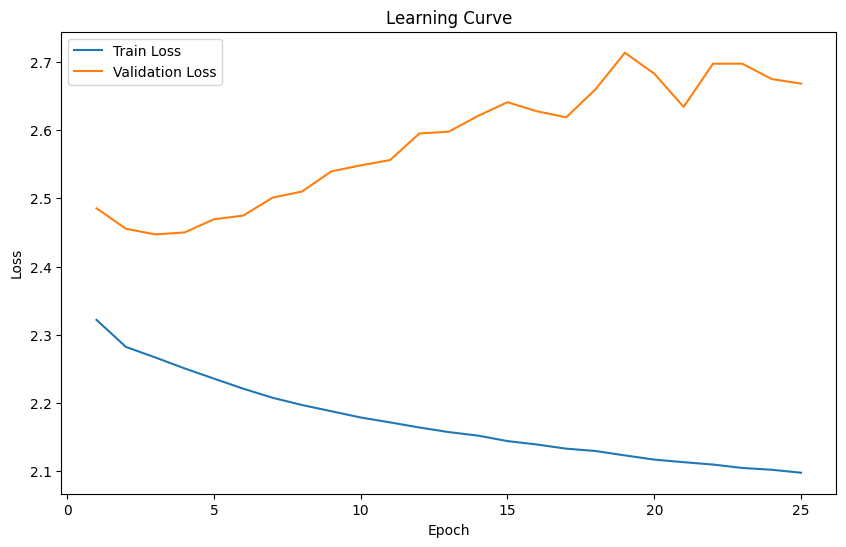

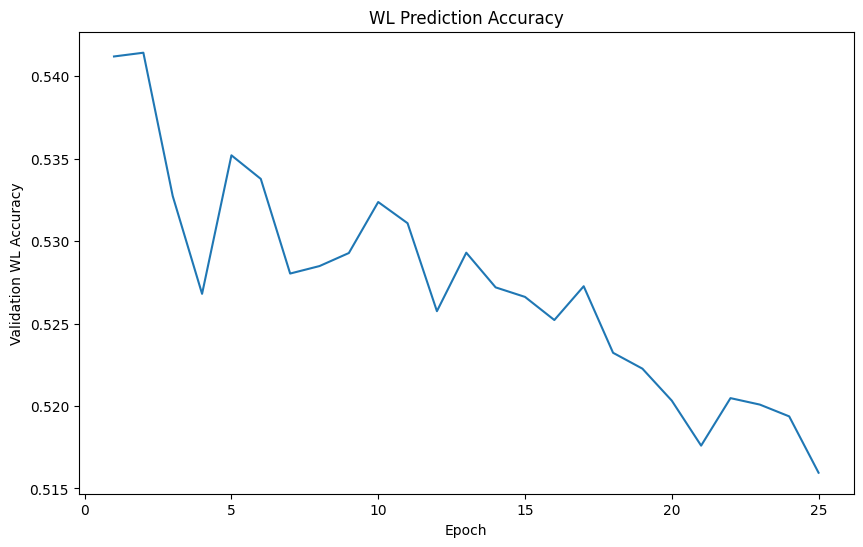

In [26]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
plt.plot(epochs, val_accs)
plt.xlabel("Epoch")
plt.ylabel("Validation WL Accuracy")
plt.title("WL Prediction Accuracy")
plt.show()


In [27]:
val_wl_accuracy = ((torch.sigmoid(model(tXva_pid.to(device), tXva_den.to(device))[0]) >= 0.5).float().cpu() == tyva_wl).float().mean().item() * 100

print(val_wl_accuracy)

51.59561038017273


New pure regression model for main box score stats
=

In [20]:
# -----------------------
# CONFIG
# -----------------------
TARGET_COLS = ["PTS", "AST", "REB", "BLK", "STL", "PF", "TOV"]

# -----------------------
# 1) Copy data
# -----------------------
dfX = X.copy()
dfY = Y.copy()

# Dates
dfX["GAME_DATE"] = pd.to_datetime(dfX["GAME_DATE"])
dfX["GAME_DATE_ORD"] = dfX["GAME_DATE"].map(pd.Timestamp.toordinal).astype("int32")

# -----------------------
# 2) PLAYER_ID -> embedding codes
# -----------------------
player_cat = dfX["PLAYER_ID"].astype("category")
player_codes = player_cat.cat.codes.to_numpy(dtype=np.int64)
n_players = int(player_cat.cat.categories.shape[0])

# -----------------------
# 3) Dense features
#    - scaled numeric features
#    - one-hot TEAM/OPP
# -----------------------
team_oh = pd.get_dummies(dfX["TEAM_ABBREVIATION"], prefix="team", dtype=np.float32)
opp_oh  = pd.get_dummies(dfX["OPP_ABBREVIATION"],  prefix="opp",  dtype=np.float32)

num_cols = ["DATE_DIFF_DAYS", "GAME_DATE_ORD"] + [c for c in dfX.columns if c.endswith("_30D_AVG")]
num = dfX[num_cols].to_numpy(dtype=np.float32)

x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(num).astype(np.float32)

X_dense = np.concatenate([num_scaled, team_oh.to_numpy(), opp_oh.to_numpy()], axis=1).astype(np.float32)
X_dense_dim = X_dense.shape[1]

# -----------------------
# 4) Targets (regression only)
# -----------------------
y = dfY[TARGET_COLS].to_numpy(dtype=np.float32)
y_dim = y.shape[1]

# -----------------------
# 5) Time-based split (recommended)
# -----------------------
order = np.argsort(dfX["GAME_DATE"].values)
cut = int(0.8 * len(order))
train_idx = order[:cut]
val_idx   = order[cut:]

def take(a, ii): return a[ii]

Xtr_pid = take(player_codes, train_idx)
Xva_pid = take(player_codes, val_idx)

Xtr_den = take(X_dense, train_idx)
Xva_den = take(X_dense, val_idx)

ytr = take(y, train_idx)
yva = take(y, val_idx)

# -----------------------
# 6) Scale targets (IMPORTANT for stable multi-stat learning)
# -----------------------
y_scaler = StandardScaler()
ytr_s = y_scaler.fit_transform(ytr).astype(np.float32)
yva_s = y_scaler.transform(yva).astype(np.float32)

# -----------------------
# 7) Torch tensors/loaders
# -----------------------
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

tXtr_pid = torch.tensor(Xtr_pid, dtype=torch.long)
tXva_pid = torch.tensor(Xva_pid, dtype=torch.long)

tXtr_den = torch.tensor(Xtr_den, dtype=torch.float32)
tXva_den = torch.tensor(Xva_den, dtype=torch.float32)

tytr = torch.tensor(ytr_s, dtype=torch.float32)
tyva = torch.tensor(yva_s, dtype=torch.float32)

train_ds = TensorDataset(tXtr_pid, tXtr_den, tytr)
val_ds   = TensorDataset(tXva_pid, tXva_den, tyva)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=512, shuffle=False, drop_last=False)

print("TARGET_COLS:", TARGET_COLS)
print("n_players:", n_players)
print("X_dense_dim:", X_dense_dim)
print("y_dim:", y_dim)
print("device:", device)
print("train rows:", len(train_ds), "| val rows:", len(val_ds))


TARGET_COLS: ['PTS', 'AST', 'REB', 'BLK', 'STL', 'PF', 'TOV']
n_players: 2833
X_dense_dim: 95
y_dim: 7
device: mps
train rows: 581972 | val rows: 145493


In [21]:
import torch
import torch.nn as nn

class PlayerAwareRegressor(nn.Module):
    def __init__(self, n_players: int, dense_dim: int, out_dim: int,
                 emb_dim: int = 32, hidden=(512, 256, 128), dropout=0.25):
        super().__init__()
        # This is where PLAYER_ID is explicitly used
        self.player_emb = nn.Embedding(n_players, emb_dim)

        layers = []
        in_dim = emb_dim + dense_dim
        for h in hidden:
            layers += [
                nn.Linear(in_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
            in_dim = h

        self.trunk = nn.Sequential(*layers)
        self.head  = nn.Linear(in_dim, out_dim)

    def forward(self, player_id, x_dense):
        emb = self.player_emb(player_id)          # (B, emb_dim)
        x = torch.cat([emb, x_dense], dim=1)      # (B, emb_dim + dense_dim)
        h = self.trunk(x)
        return self.head(h)                       # (B, out_dim)

model = PlayerAwareRegressor(n_players=n_players, dense_dim=X_dense_dim, out_dim=y_dim).to(device)
model


PlayerAwareRegressor(
  (player_emb): Embedding(2833, 32)
  (trunk): Sequential(
    (0): Linear(in_features=127, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
  )
  (head): Linear(in_features=128, out_features=7, bias=True)
)

Epoch 01 | train 0.2835 | val 0.2744 | lr 1.00e-03
Epoch 02 | train 0.2793 | val 0.2741 | lr 1.00e-03
Epoch 03 | train 0.2779 | val 0.2740 | lr 1.00e-03
Epoch 04 | train 0.2769 | val 0.2739 | lr 1.00e-03
Epoch 05 | train 0.2759 | val 0.2745 | lr 1.00e-03
Epoch 06 | train 0.2753 | val 0.2743 | lr 1.00e-03
Epoch 07 | train 0.2748 | val 0.2747 | lr 1.00e-03
Epoch 08 | train 0.2742 | val 0.2754 | lr 5.00e-04
Epoch 09 | train 0.2730 | val 0.2750 | lr 5.00e-04
Epoch 10 | train 0.2727 | val 0.2756 | lr 5.00e-04
Epoch 11 | train 0.2725 | val 0.2759 | lr 5.00e-04
Epoch 12 | train 0.2723 | val 0.2763 | lr 2.50e-04
Epoch 13 | train 0.2716 | val 0.2764 | lr 2.50e-04
Epoch 14 | train 0.2715 | val 0.2764 | lr 2.50e-04
Epoch 15 | train 0.2712 | val 0.2768 | lr 2.50e-04
Epoch 16 | train 0.2713 | val 0.2770 | lr 1.25e-04
Epoch 17 | train 0.2707 | val 0.2768 | lr 1.25e-04
Epoch 18 | train 0.2708 | val 0.2767 | lr 1.25e-04
Epoch 19 | train 0.2706 | val 0.2773 | lr 1.25e-04
Epoch 20 | train 0.2706 | val 0

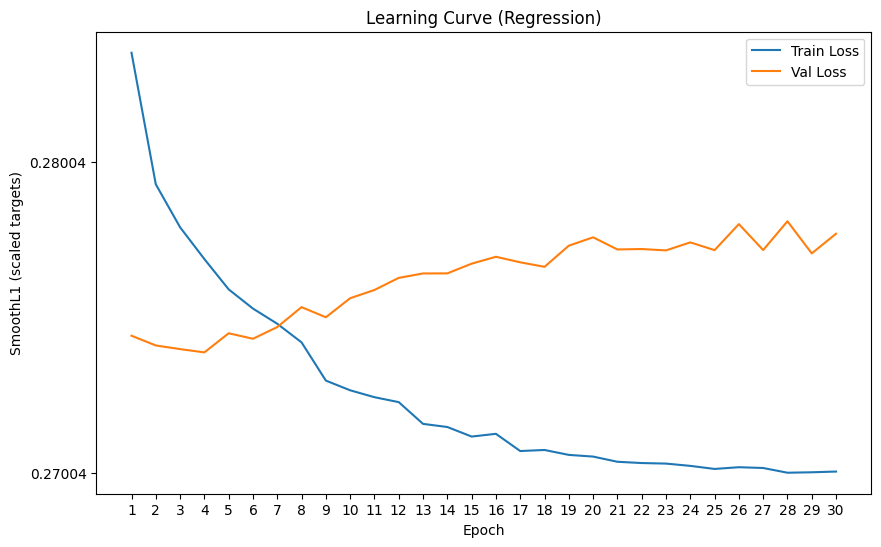

In [22]:
import matplotlib.pyplot as plt

# ALL CHATGPTT

loss_fn = nn.SmoothL1Loss()  # robust regression loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

EPOCHS = 30

train_losses = []
val_losses = []

def eval_epoch():
    model.eval()
    total = 0.0
    n = 0
    with torch.no_grad():
        for pid, xd, yb in val_loader:
            pid, xd, yb = pid.to(device), xd.to(device), yb.to(device)
            pred = model(pid, xd)
            loss = loss_fn(pred, yb)
            bs = pid.size(0)
            total += loss.item() * bs
            n += bs
    return total / n

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = 0.0
    n = 0

    for pid, xd, yb in train_loader:
        pid, xd, yb = pid.to(device), xd.to(device), yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        pred = model(pid, xd)
        loss = loss_fn(pred, yb)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        bs = pid.size(0)
        total += loss.item() * bs
        n += bs

    train_loss = total / n
    val_loss = eval_epoch()
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f} | lr {lr:.2e}")

# plots
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("SmoothL1 (scaled targets)")
plt.title("Learning Curve (Regression)")
plt.legend()

# ticks
plt.xticks(np.arange(1, EPOCHS + 1, 1))
plt.yticks(np.arange(min(train_losses),
                     max(train_losses),
                     0.01))

plt.show()


try 60 dasy

reduced learnign rate on plateau.

juse different schedlers

In [23]:
model.eval()

# Get validation predictions (scaled)
with torch.no_grad():
    pred_scaled = model(tXva_pid.to(device), tXva_den.to(device)).cpu().numpy()
    y_true_scaled = tyva.cpu().numpy()

# Unscale back to real stat units
pred = y_scaler.inverse_transform(pred_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

# Pick 10 random validation rows
np.random.seed(42)
rand_idx = np.random.choice(len(pred), size=10, replace=False)

for i, idx in enumerate(rand_idx, 1):
    print(f"\nGame {i}")
    print("-" * 40)

    for j, stat in enumerate(TARGET_COLS):
        true_val = y_true[idx, j]
        pred_val = pred[idx, j]
        print(f"{stat:>4}:  True = {true_val:6.2f} | Pred = {pred_val:6.2f}")



Game 1
----------------------------------------
 PTS:  True =  13.00 | Pred =  12.03
 AST:  True =   1.00 | Pred =   1.52
 REB:  True =   3.00 | Pred =   6.15
 BLK:  True =   0.00 | Pred =   0.31
 STL:  True =   1.00 | Pred =   0.50
  PF:  True =   1.00 | Pred =   2.14
 TOV:  True =   1.00 | Pred =   1.53

Game 2
----------------------------------------
 PTS:  True =  28.00 | Pred =  26.03
 AST:  True =   8.00 | Pred =   7.85
 REB:  True =   9.00 | Pred =   7.52
 BLK:  True =   0.00 | Pred =   0.48
 STL:  True =   2.00 | Pred =   1.19
  PF:  True =   2.00 | Pred =   1.61
 TOV:  True =   5.00 | Pred =   3.38

Game 3
----------------------------------------
 PTS:  True =  11.00 | Pred =   5.43
 AST:  True =   3.00 | Pred =   1.82
 REB:  True =   3.00 | Pred =   1.93
 BLK:  True =   0.00 | Pred =   0.10
 STL:  True =   1.00 | Pred =   0.44
  PF:  True =   0.00 | Pred =   1.19
 TOV:  True =   2.00 | Pred =   0.83

Game 4
----------------------------------------
 PTS:  True =   3.00 | Pred

In [24]:
model.eval()

with torch.no_grad():
    pred_scaled = model(tXva_pid.to(device), tXva_den.to(device)).cpu().numpy()
    y_true_scaled = tyva.cpu().numpy()

# Unscale back to real units
pred = y_scaler.inverse_transform(pred_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)


In [25]:
val_rows = val_idx

val_info = dfX.iloc[val_rows][["PLAYER_ID", "PLAYER_NAME"]].reset_index(drop=True)

# Absolute errors
errors = np.abs(pred - y_true)
error_df = pd.DataFrame(errors, columns=[f"{c}_diff" for c in TARGET_COLS])

# True stats (for computing PPG)
true_df = pd.DataFrame(y_true, columns=TARGET_COLS)

val_full = pd.concat([val_info, true_df, error_df], axis=1)


In [78]:
player_stats = (
    val_full
    .groupby(["PLAYER_ID", "PLAYER_NAME"], as_index=False)
    .mean()
)


In [79]:
player_stats = player_stats[player_stats["PTS"] > 15]



diff_cols = [c for c in player_stats.columns if c.endswith("_diff")]

player_stats["overall_avg_diff"] = player_stats[diff_cols].mean(axis=1)

player_stats["AVERAGE_ERROR"] = (player_stats['PTS_diff']/player_stats['PTS'] +
                             player_stats['AST_diff']/player_stats['AST'] +
                             player_stats['REB_diff']/player_stats['REB'] +
                             player_stats['BLK_diff']/player_stats['BLK'] +
                             player_stats['STL_diff']/player_stats['STL'] +
                             player_stats['PF_diff']/player_stats['PF'] +
                             player_stats['TOV_diff']/player_stats['TOV']
                                 )/7

outChannel = ['PTS', 'AST', 'REB', 'BLK', 'STL', 'PF', 'TOV']

for stat in outChannel:
    player_stats[f"{stat}_ERROR"] = player_stats[f"{stat}_diff"]/player_stats[f"{stat}"]


In [80]:
top_1000 = (
    player_stats
    .sort_values("AVERAGE_ERROR", ascending=True)
    .head(1000)
    .reset_index(drop=True)
)

top_1000


,PLAYER_ID,PLAYER_NAME,PTS,AST,REB,BLK,STL,PF,TOV,PTS_diff,...,TOV_diff,overall_avg_diff,AVERAGE_ERROR,PTS_ERROR,AST_ERROR,REB_ERROR,BLK_ERROR,STL_ERROR,PF_ERROR,TOV_ERROR
0,203507,Giannis Antetokounmpo,29.847645,6.041551,11.443213,1.091413,1.019391,2.825485,3.401662,6.982011,...,1.509803,2.394011,0.473281,0.233922,0.397832,0.264562,0.803316,0.745162,0.424331,0.443843
1,203954,Joel Embiid,30.389091,4.105454,10.283636,1.450909,0.996364,2.672727,3.301818,7.841596,...,1.455963,2.429049,0.480092,0.258040,0.436004,0.284071,0.709332,0.792254,0.439984,0.440958
2,203999,Nikola Jokić,26.903465,9.168317,12.289604,0.745049,1.433168,2.514852,3.371287,7.636171,...,1.560492,2.579189,0.483649,0.283836,0.308808,0.264764,0.977902,0.638397,0.448956,0.462877
3,1629029,Luka Dončić,30.562674,8.615599,8.562675,0.509749,1.331476,2.339833,4.036211,6.929524,...,1.469234,2.319885,0.506488,0.226732,0.309858,0.292367,1.163899,0.701071,0.487478,0.364013
4,1628983,Shai Gilgeous-Alexander,29.569445,6.038889,4.969444,0.877778,1.544444,2.369444,2.508333,7.055663,...,1.271239,2.199746,0.506989,0.238613,0.351049,0.398425,0.912382,0.647891,0.493756,0.506806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,1629640,Keldon Johnson,15.567568,2.113022,5.535626,0.243243,0.687961,1.938575,1.312039,5.383762,...,0.857278,1.701045,0.758948,0.345832,0.586133,0.407155,1.747879,1.038822,0.533423,0.653393
99,1629014,Anfernee Simons,16.886364,3.659091,2.670455,0.130682,0.568182,1.855114,1.761364,6.731916,...,1.062301,1.860182,0.818350,0.398660,0.482742,0.538342,1.970298,1.129522,0.605777,0.603113
100,1630560,Cam Thomas,15.219917,2.153527,2.493776,0.145228,0.485477,1.385892,1.477178,7.644956,...,0.970555,1.968866,0.907416,0.502299,0.713841,0.685324,1.820933,1.197082,0.775402,0.657033
101,202711,Bojan Bogdanovic,17.953308,1.964981,3.704280,0.070039,0.556420,1.708171,1.875486,6.068399,...,1.055324,1.696214,0.962014,0.338010,0.589017,0.450184,3.004578,1.165739,0.623874,0.562694


In [71]:
top_1000.sort_values(['AVERAGE_ERROR','PTS'], ascending=True).reset_index(drop=True)

,PLAYER_ID,PLAYER_NAME,PTS,AST,REB,BLK,STL,PF,TOV,PTS_diff,...,STL_error,PF_error,TOV_error,PTS_ERROR,AST_ERROR,REB_ERROR,BLK_ERROR,STL_ERROR,PF_ERROR,TOV_ERROR
0,203507,Giannis Antetokounmpo,29.847645,6.041551,11.443213,1.091413,1.019391,2.825485,3.401662,6.982011,...,0.745162,0.424331,0.443843,0.233922,0.397832,0.264562,0.803316,0.745162,0.424331,0.443843
1,203076,Anthony Davis,24.043011,3.164875,11.304660,2.093190,1.164875,2.222222,2.118279,7.402800,...,0.772184,0.524393,0.567135,0.307898,0.512833,0.307463,0.607804,0.772184,0.524393,0.567135
2,1641705,Victor Wembanyama,23.019108,3.515924,10.853503,3.414013,1.133758,2.331210,3.273885,6.985889,...,0.730438,0.531210,0.509332,0.303482,0.445101,0.398543,0.814530,0.730438,0.531210,0.509332
3,1630567,Scottie Barnes,17.572727,5.063636,7.633333,1.069697,1.215152,2.263636,2.369697,5.489753,...,0.755433,0.524430,0.532494,0.312402,0.434034,0.362629,0.867785,0.755433,0.524430,0.532494


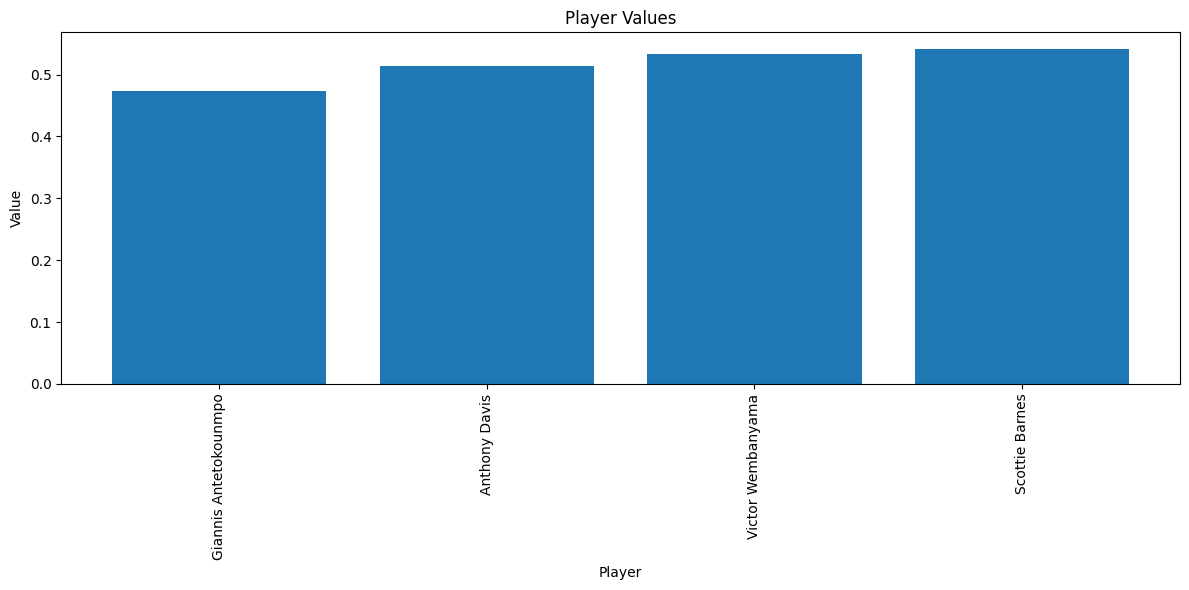

In [72]:
plt.figure(figsize=(12,6))
plt.bar(top_1000["PLAYER_NAME"].head(50), top_1000['AVERAGE_ERROR'].head(50))

plt.xticks(rotation=90)   # rotate names so they don’t overlap
plt.xlabel("Player")
plt.ylabel("Value")
plt.title("Player Values")
plt.tight_layout()
plt.show()

consider ensemble training.

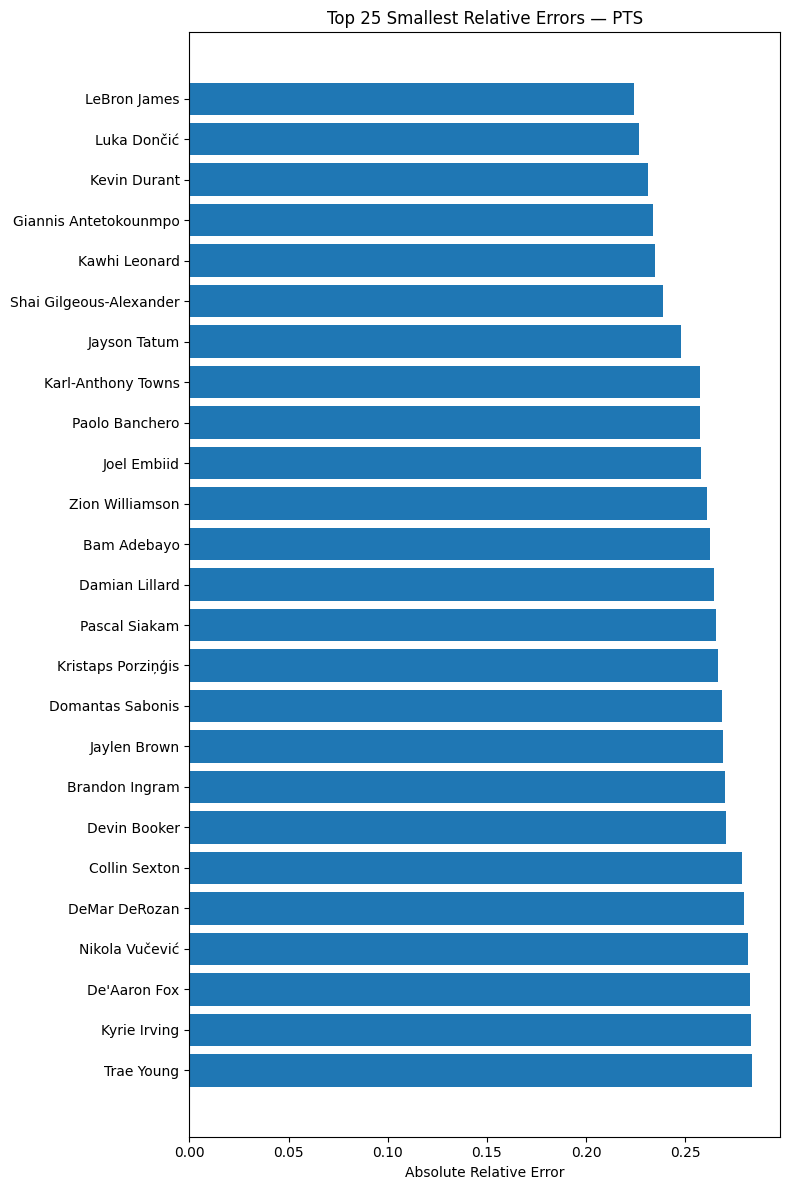

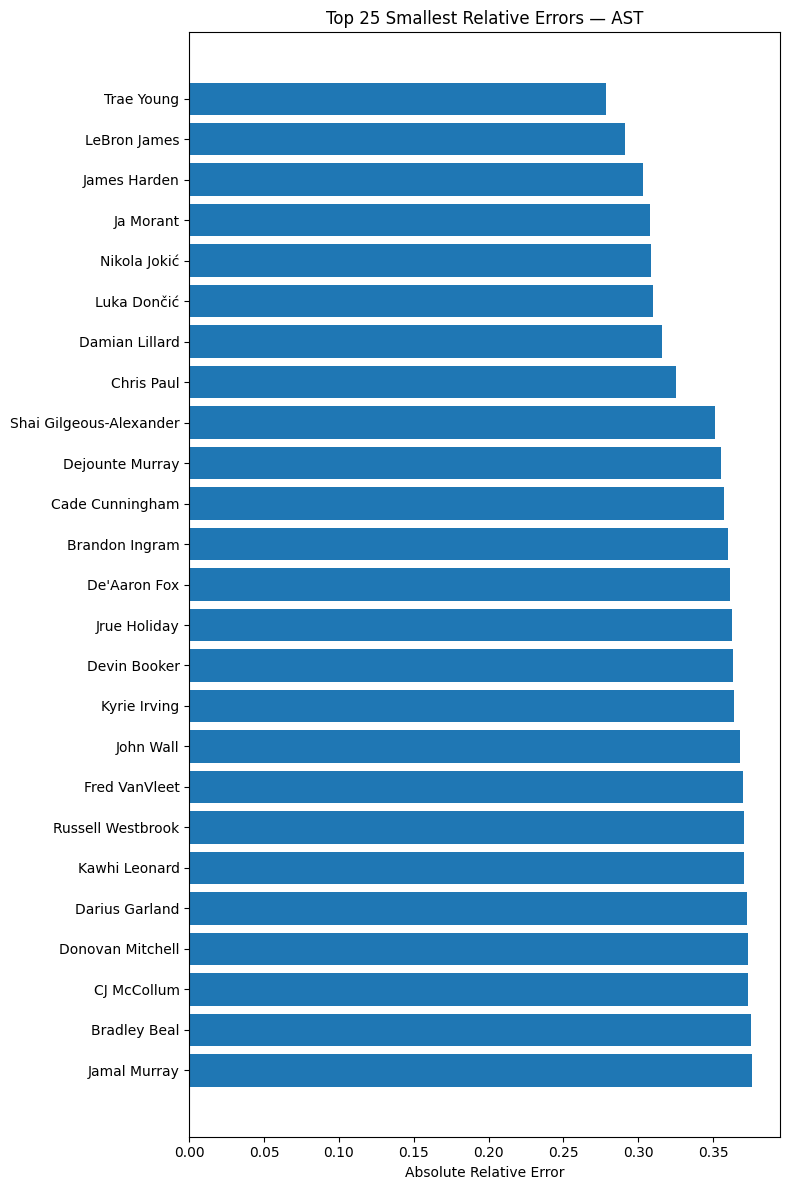

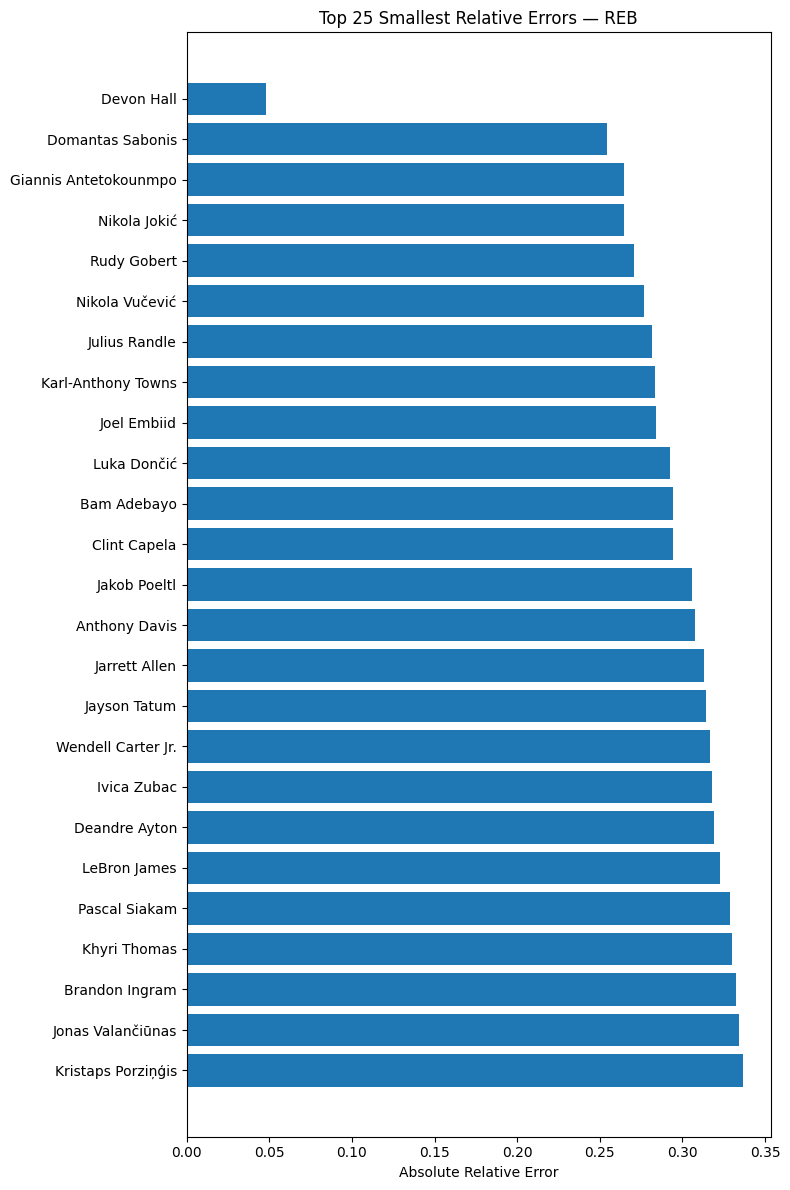

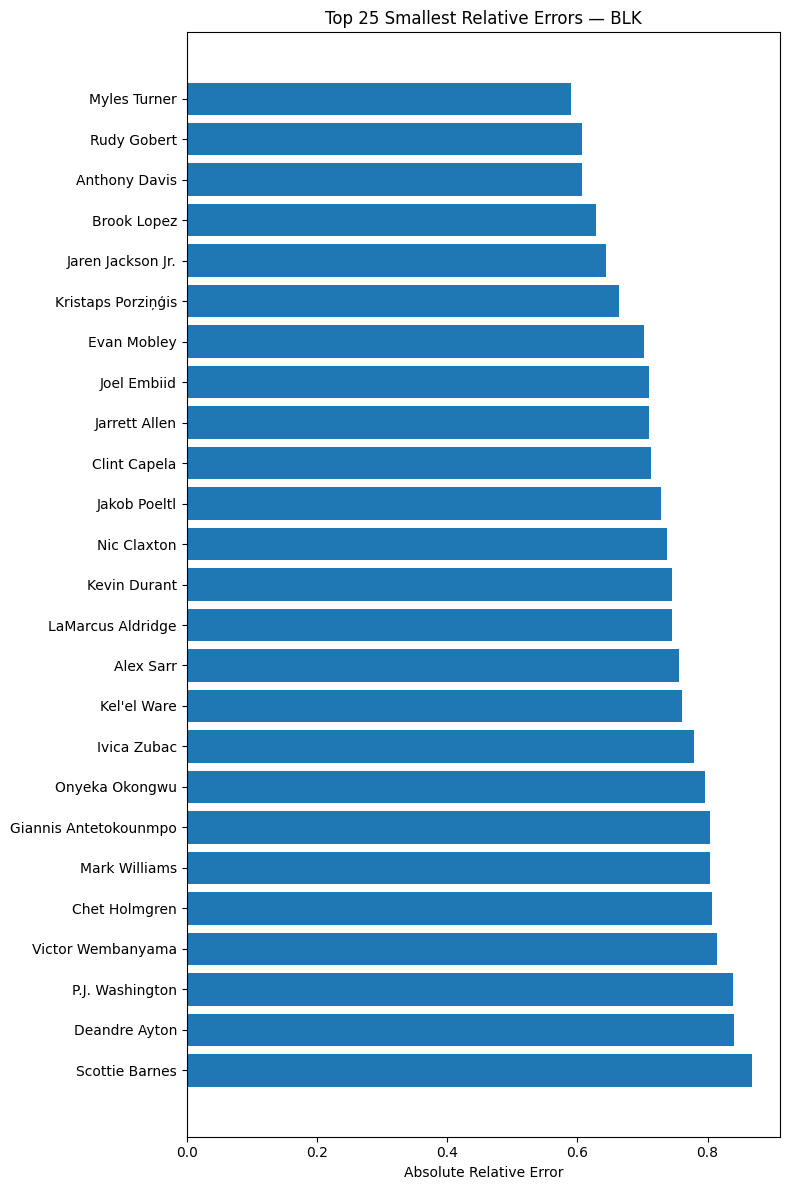

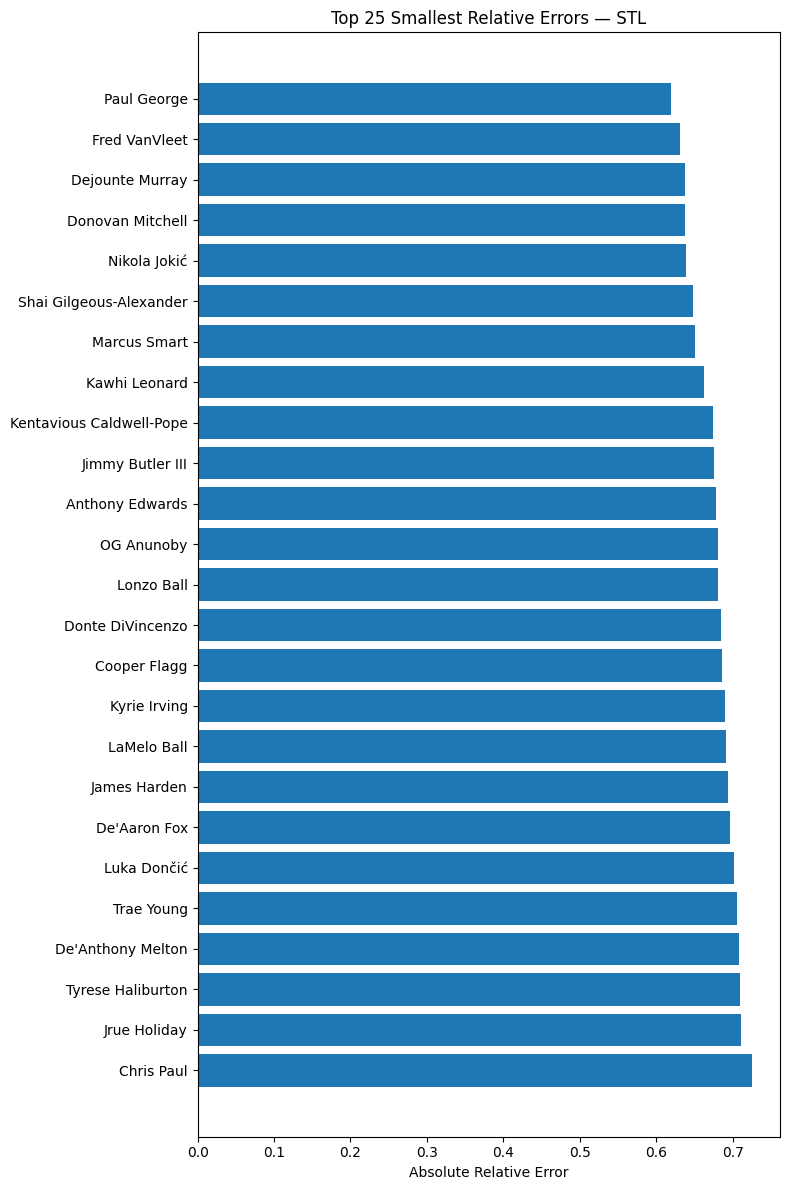

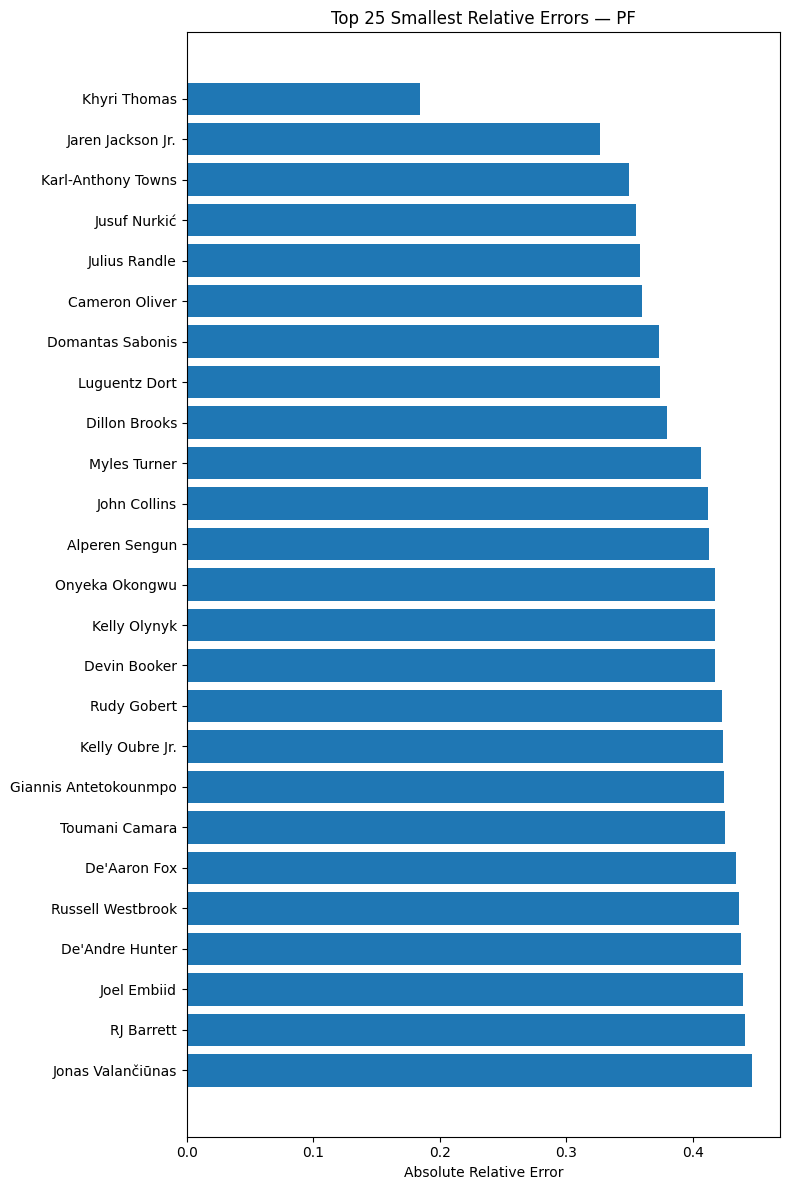

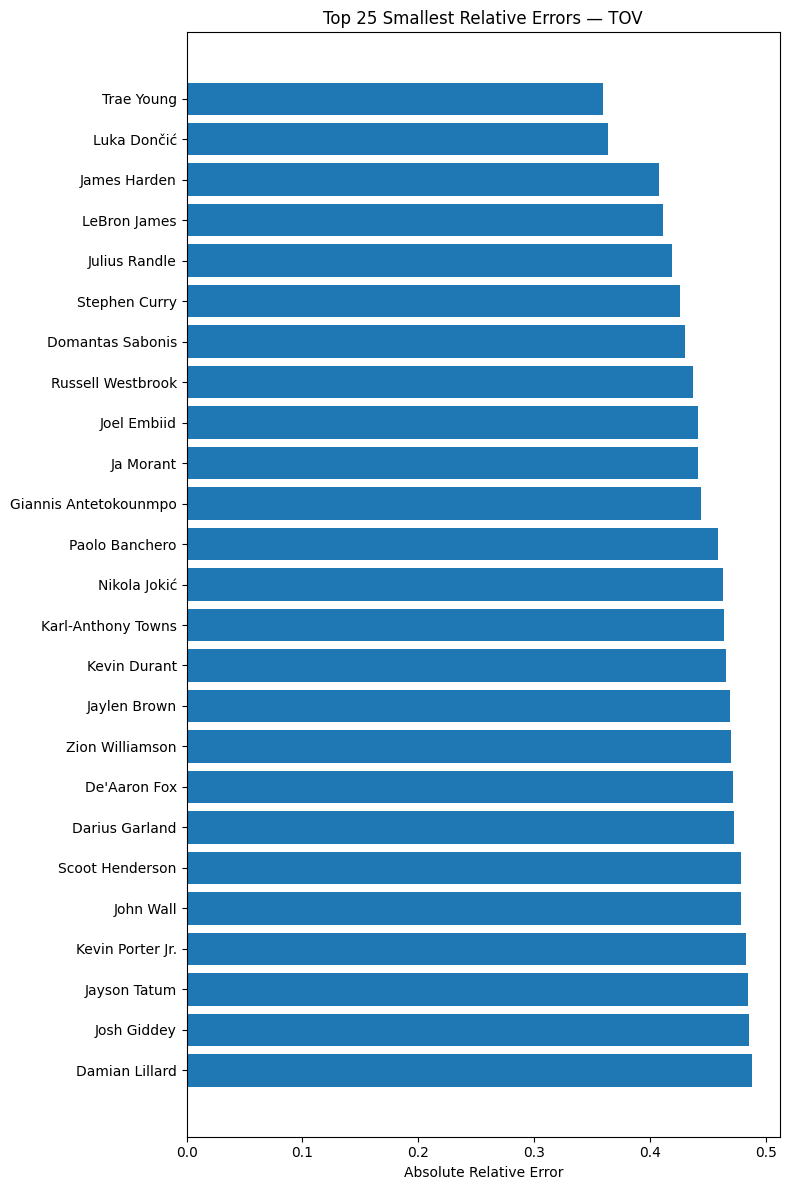

In [68]:
import numpy as np
import matplotlib.pyplot as plt

outChannel = ['PTS', 'AST', 'REB', 'BLK', 'STL', 'PF', 'TOV']

for stat in outChannel:

    err_col = f"{stat}_ERROR"

    if err_col not in player_stats.columns:
        continue

    df = player_stats[["PLAYER_NAME", err_col]].replace([np.inf, -np.inf], np.nan).dropna().copy()

    df["abs_err"] = df[err_col].abs()

    top25 = df.sort_values("abs_err", ascending=True).head(25)

    plt.figure(figsize=(8, 12))
    plt.barh(top25["PLAYER_NAME"][::-1], top25["abs_err"][::-1])
    plt.title(f"Top 25 Smallest Relative Errors — {stat}")
    plt.xlabel("Absolute Relative Error")
    plt.tight_layout()
    plt.show()
